<a href="https://colab.research.google.com/github/abelhugo/series-temporales-multivariantes/blob/master/BUSCADOR_UDEMY_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [34]:
# FECHA DE INICIO Y FIN DEL PERIODO DE  DATOS DE APRENDIZAJE
start_dt = '2000-01-01'
end_dt = '2024-02-29'

# **INDICE O VALOR A PRONOSTICAR, CON SIGLAS DE YAHOO FINANCE**
ticker_target = '^GSPC'

raw_data = yfinance.download (tickers = '^GSPC ^DJI ^VIX ^TNX ^GDAXI ^FTSE EURUSD=X', start = start_dt,
                              end = end_dt, interval = "1d", group_by = 'ticker', auto_adjust = True, threads = True)



[*********************100%%**********************]  7 of 7 completed


In [35]:
# Hace una copia del dataset
df_comp = raw_data.copy()

In [36]:
# Cambia los nombres de las columnas para hacer mas facil el manejo
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dji']= df_comp['^DJI'].Close[:]
df_comp['vix'] = df_comp['^VIX'].Close[:]
df_comp['tnx'] = df_comp['^TNX'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['fts'] = df_comp['^FTSE'].Close[:]
df_comp['eurusd'] = df_comp['EURUSD=X'].Close[:]

In [37]:
# elimina las columnas con nobres viejos
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^DJI']
del df_comp['^VIX']
del df_comp['^TNX']
del df_comp['^GDAXI']
del df_comp['^FTSE']
del df_comp['EURUSD=X']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

#  elimina filas con posibles datos nulos
df_comp=df_comp.dropna()


In [46]:
df_comp

Ticker,spx,dji,vix,tnx,dax,fts,eurusd,ret_spx,ret_dji,ret_vix,...,ret_dax,ret_fts,ret_eurusd,norm_ret_spx,norm_ret_dji,norm_ret_vix,norm_ret_tnx,norm_ret_dax,norm_ret_fts,norm_ret_eurusd
Price,,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,1070.119995,9899.049805,16.770000,4.392,3821.199951,4410.000000,1.196501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,1066.619995,9853.639648,16.270000,4.380,3809.260010,4378.899902,1.208897,-0.327066,-0.458732,-2.981515,...,-0.312466,-0.705218,1.036029,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2003-12-03,1064.729980,9873.419922,16.629999,4.410,3875.659912,4392.000000,1.212298,-0.177197,0.200741,2.212653,...,1.743118,0.299164,0.281255,54.177615,-43.759881,-74.212394,-250.680952,-557.858932,-42.421532,27.147437
2003-12-04,1069.719971,9930.820312,16.299999,4.369,3874.780029,4378.200195,1.208094,0.468663,0.581363,-1.984365,...,-0.022703,-0.314203,-0.346723,-143.292892,-126.732427,66.555612,340.268838,7.265688,44.554076,-33.466586
2003-12-05,1061.500000,9862.679688,17.090000,4.215,3841.729980,4367.000000,1.218695,-0.768423,-0.686153,4.846632,...,-0.852953,-0.255817,0.877452,234.944131,149.575858,-162.556029,1290.078684,272.974840,36.274950,84.693801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,5087.029785,39069.109375,14.540000,4.327,17370.449219,7684.500000,1.082040,2.112288,1.183229,-5.215125,...,1.474053,0.287113,0.067084,-645.829164,-257.934370,174.915299,-16.927547,-471.748519,-40.712618,6.475104
2024-02-23,5088.799805,39131.531250,13.750000,4.260,17419.330078,7706.299805,1.082567,0.034795,0.159773,-5.433287,...,0.281402,0.283685,0.048718,-10.638446,-34.829225,182.232459,566.715893,-90.058633,-40.226646,4.702336


## CREA LOS RETORNOS

In [38]:
# crea los retornos de cada indice
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_dji'] = df_comp.dji.pct_change(1).mul(100)
df_comp['ret_vix'] = df_comp.vix.pct_change(1).mul(100)
df_comp['ret_tnx'] = df_comp.tnx.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_fts'] = df_comp.fts.pct_change(1).mul(100)
df_comp['ret_eurusd'] = df_comp.eurusd.pct_change(1).mul(100)

In [40]:
# crea retornos normalizados

df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_dji'] = df_comp.ret_dji.div(df_comp.ret_dji[1])*100
df_comp['norm_ret_vix'] = df_comp.ret_vix.div(df_comp.ret_vix[1])*100
df_comp['norm_ret_tnx'] = df_comp.ret_tnx.div(df_comp.ret_tnx[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_fts'] = df_comp.ret_fts.div(df_comp.ret_fts[1])*100
df_comp['norm_ret_eurusd'] = df_comp.ret_eurusd.div(df_comp.ret_eurusd[1])*100

In [41]:
# divide los datos en entrenamiento y testeo
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [45]:
df

Ticker,spx,dji,vix,tnx,dax,fts,eurusd,ret_spx,ret_dji,ret_vix,...,ret_dax,ret_fts,ret_eurusd,norm_ret_spx,norm_ret_dji,norm_ret_vix,norm_ret_tnx,norm_ret_dax,norm_ret_fts,norm_ret_eurusd
Price,,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,1070.119995,9899.049805,16.770000,4.392,3821.199951,4410.000000,1.196501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,1066.619995,9853.639648,16.270000,4.380,3809.260010,4378.899902,1.208897,-0.327066,-0.458732,-2.981515,...,-0.312466,-0.705218,1.036029,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2003-12-03,1064.729980,9873.419922,16.629999,4.410,3875.659912,4392.000000,1.212298,-0.177197,0.200741,2.212653,...,1.743118,0.299164,0.281255,54.177615,-43.759881,-74.212394,-250.680952,-557.858932,-42.421532,27.147437
2003-12-04,1069.719971,9930.820312,16.299999,4.369,3874.780029,4378.200195,1.208094,0.468663,0.581363,-1.984365,...,-0.022703,-0.314203,-0.346723,-143.292892,-126.732427,66.555612,340.268838,7.265688,44.554076,-33.466586
2003-12-05,1061.500000,9862.679688,17.090000,4.215,3841.729980,4367.000000,1.218695,-0.768423,-0.686153,4.846632,...,-0.852953,-0.255817,0.877452,234.944131,149.575858,-162.556029,1290.078684,272.974840,36.274950,84.693801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-04,3297.590088,28807.630859,16.049999,1.603,13281.740234,7439.799805,1.106293,1.498041,1.435997,-10.684475,...,1.813310,1.549213,-0.242282,-458.024021,-313.035739,358.357300,-1998.540308,-580.322940,-219.678731,-23.385651
2020-02-05,3334.689941,29290.849609,15.150000,1.649,13478.330078,7482.500000,1.104728,1.125060,1.677398,-5.607475,...,1.480151,0.573943,-0.141408,-343.985361,-365.659404,188.074701,-1050.273484,-473.700304,-81.385203,-13.649019


In [44]:
df_test

Ticker,spx,dji,vix,tnx,dax,fts,eurusd,ret_spx,ret_dji,ret_vix,...,ret_dax,ret_fts,ret_eurusd,norm_ret_spx,norm_ret_dji,norm_ret_vix,norm_ret_tnx,norm_ret_dax,norm_ret_fts,norm_ret_eurusd
Price,,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-11,3357.750000,29276.339844,15.18,1.590,13627.839844,7499.399902,1.091346,0.168847,-0.001641,0.930853,...,0.991620,0.704991,-0.327405,-51.624807,0.357752,-31.220822,-1017.316344,-317.353333,-99.967913,-31.601964
2020-02-12,3379.449951,29551.419922,13.74,1.630,13749.780273,7534.399902,1.091941,0.646265,0.939599,-9.486169,...,0.894789,0.466704,0.054594,-197.594492,-204.824957,318.166128,-920.747422,-286.363900,-66.178721,5.269534
2020-02-13,3373.939941,29423.310547,14.15,1.617,13745.429688,7452.000000,1.087595,-0.163045,-0.433513,2.983987,...,-0.031641,-1.093649,-0.398062,49.850645,94.502451,-100.082937,291.900070,10.126271,155.079669,-38.421955
2020-02-14,3380.159912,29398.080078,13.68,1.588,13744.209961,7409.100098,1.084599,0.184353,-0.085750,-3.321550,...,-0.008874,-0.575683,-0.275489,-56.365768,18.692797,111.404790,656.394482,2.839891,81.631973,-26.590885
2020-02-17,3380.159912,29398.080078,13.68,1.588,13783.889648,7433.299805,1.084175,0.000000,0.000000,0.000000,...,0.288701,0.326621,-0.039029,-0.000000,-0.000000,-0.000000,-0.000000,-92.394481,-46.314980,-3.767211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,5087.029785,39069.109375,14.54,4.327,17370.449219,7684.500000,1.082040,2.112288,1.183229,-5.215125,...,1.474053,0.287113,0.067084,-645.829164,-257.934370,174.915299,-16.927547,-471.748519,-40.712618,6.475104
2024-02-23,5088.799805,39131.531250,13.75,4.260,17419.330078,7706.299805,1.082567,0.034795,0.159773,-5.433287,...,0.281402,0.283685,0.048718,-10.638446,-34.829225,182.232459,566.715893,-90.058633,-40.226646,4.702336


In [85]:
# create variables that will help us change the periods easily instead of typing them up every time
# crea variables que permitirán cambiar facilmente las fechas en culquier momento
# HAY QUE ASEGURARSE QUE LAS FECHAS INICIO Y FIN SEAN DÍAS HÁBILES, de lo contrario dará error
start_date = "2020-02-11"
end_date = "2020-07-13"

## ARMAX (es un ARMA pero con otras variables de prediccion

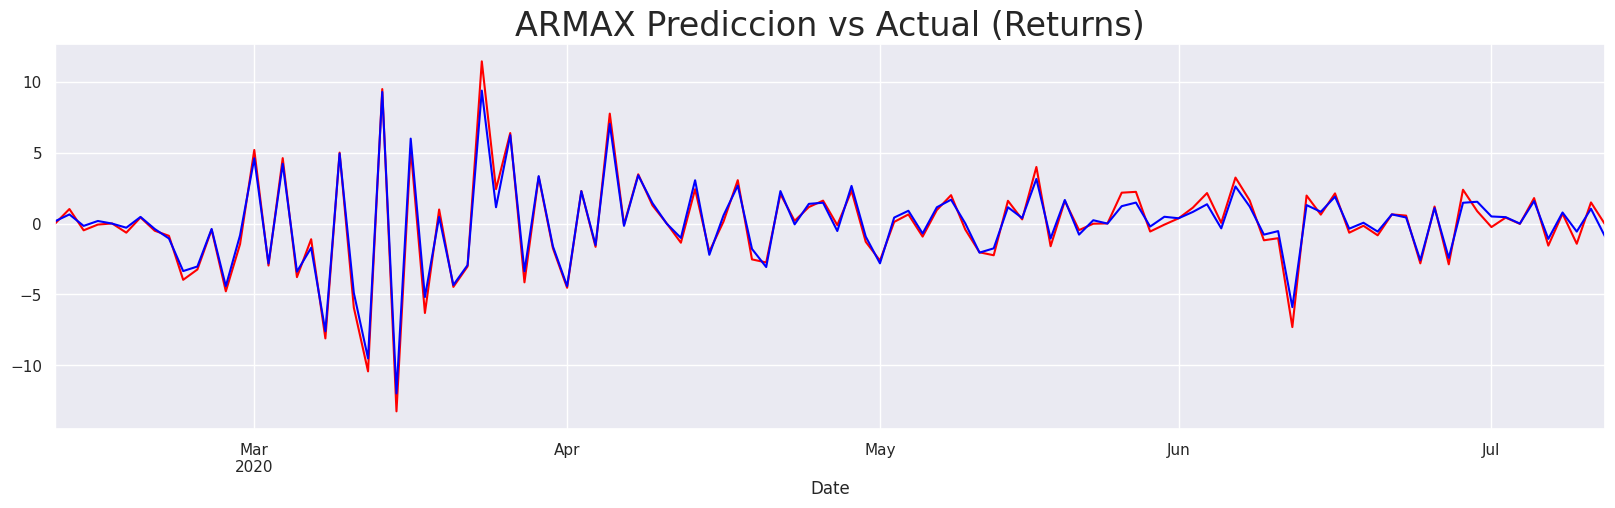

In [107]:
model_ret_armax = ARIMA(df.ret_spx[1:], exog = df[["ret_dji","ret_vix","ret_tnx","ret_dax","ret_fts","ret_eurusd"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date,
                                          exog = df_test[["ret_dji","ret_vix","ret_tnx","ret_dax","ret_fts","ret_eurusd"]][start_date:end_date])

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_spx[start_date:end_date].plot(color = "blue")
plt.title("ARMAX Prediccion vs Actual (Returns)", size = 24)
plt.show()

##                                      SARIMAX        

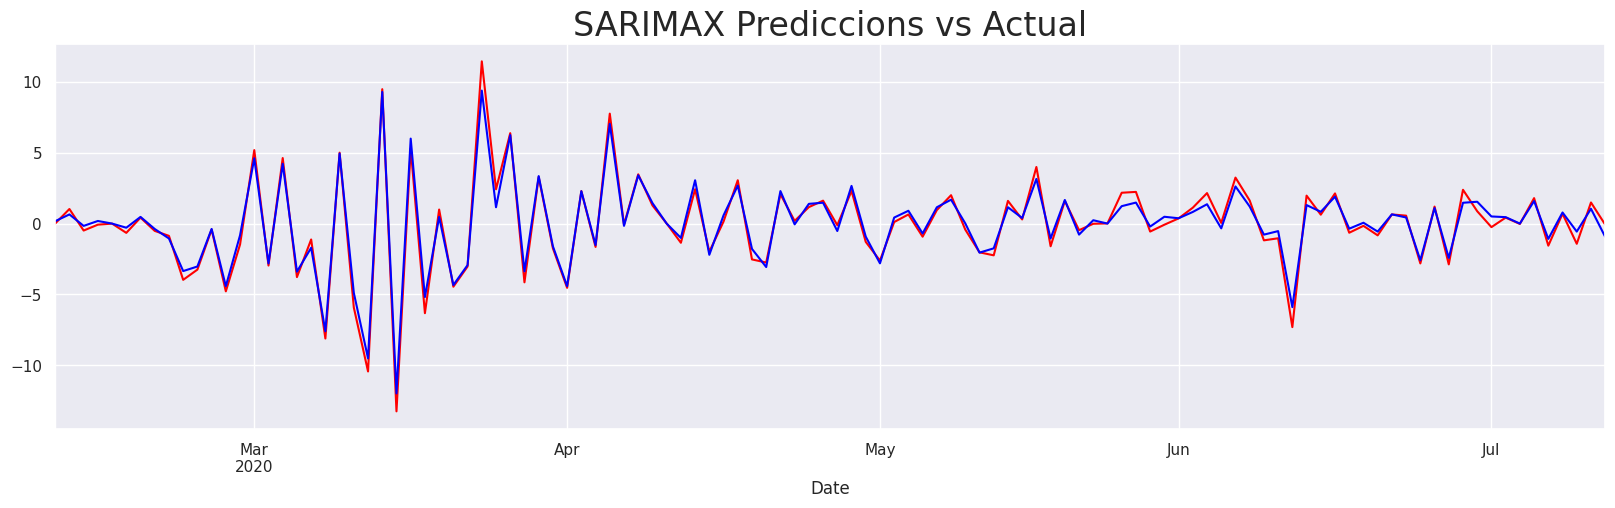

In [108]:
#end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_spx[1:], exog = df[["ret_dji","ret_vix","ret_tnx","ret_dax","ret_fts","ret_eurusd"]][1:],
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date,
                                              exog = df_test[["ret_dji","ret_vix","ret_tnx","ret_dax","ret_fts","ret_eurusd"]][start_date:end_date])

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_spx[start_date:end_date].plot(color = "blue")
plt.title("SARIMAX Prediccions vs Actual", size = 24)
plt.show()